In [100]:
import pandas as pd
import numpy as np
import requests
import zipfile
import io
import os
import seaborn as sns

from matplotlib import pyplot as plt
from datetime import datetime

In [101]:
# Define the URL for the zip file and the local filename to use
url = 'http://ergast.com/downloads/f1db_csv.zip'
filename = 'f1db_csv.zip'

# Create a data directory if it doesn't exist
if not os.path.exists('../data'):
    os.makedirs('../data')

# Download the zip file
response = requests.get(url)

# Unzip the file into the data directory
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_file:
    zip_file.extractall('../data')

dataframes = {}

# Loop through the csv files in the data directory
for csv_file in os.listdir('../data'):
    if csv_file.endswith('.csv'):
        # Read the csv file into a dataframe 
        df_name = csv_file.replace('.csv', '')
        dataframes[df_name] = pd.read_csv(f'../data/{csv_file}')

## Question 1
### Does experience (years in Formula 1) correlate to the frequency of accidents (caused by driver)?

In [102]:
dataframes.keys()

dict_keys(['circuits', 'constructors', 'constructor_results', 'constructor_standings', 'drivers', 'driver_standings', 'lap_times', 'pit_stops', 'qualifying', 'races', 'results', 'seasons', 'sprint_results', 'status'])

In [103]:
drivers = pd.DataFrame(dataframes['drivers'])
drivers.head()

,driverId,driverRef,number,code,forename,surname,dob,nationality,url
0,1,hamilton,44,HAM,Lewis,Hamilton,1985-01-07,British,http://en.wikipedia.org/wiki/Lewis_Hamilton
1,2,heidfeld,\N,HEI,Nick,Heidfeld,1977-05-10,German,http://en.wikipedia.org/wiki/Nick_Heidfeld
2,3,rosberg,6,ROS,Nico,Rosberg,1985-06-27,German,http://en.wikipedia.org/wiki/Nico_Rosberg
3,4,alonso,14,ALO,Fernando,Alonso,1981-07-29,Spanish,http://en.wikipedia.org/wiki/Fernando_Alonso
4,5,kovalainen,\N,KOV,Heikki,Kovalainen,1981-10-19,Finnish,http://en.wikipedia.org/wiki/Heikki_Kovalainen


In [104]:
driver_standings = pd.DataFrame(dataframes['driver_standings'])
driver_standings.head()

,driverStandingsId,raceId,driverId,points,position,positionText,wins
0,1,18,1,10.0,1,1,1
1,2,18,2,8.0,2,2,0
2,3,18,3,6.0,3,3,0
3,4,18,4,5.0,4,4,0
4,5,18,5,4.0,5,5,0


In [105]:
results = pd.DataFrame(dataframes['results'])
results.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1
3,4,18,4,4,5,11,4,4,4,5.0,58,+17.181,5707797,58,7,1:28.603,215.464,1
4,5,18,5,1,23,3,5,5,5,4.0,58,+18.014,5708630,43,1,1:27.418,218.385,1


In [106]:
races = pd.DataFrame(dataframes['races'])
races['date']= pd.to_datetime(races['date'])
races.head()
races.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   raceId       1102 non-null   int64         
 1   year         1102 non-null   int64         
 2   round        1102 non-null   int64         
 3   circuitId    1102 non-null   int64         
 4   name         1102 non-null   object        
 5   date         1102 non-null   datetime64[ns]
 6   time         1102 non-null   object        
 7   url          1102 non-null   object        
 8   fp1_date     1102 non-null   object        
 9   fp1_time     1102 non-null   object        
 10  fp2_date     1102 non-null   object        
 11  fp2_time     1102 non-null   object        
 12  fp3_date     1102 non-null   object        
 13  fp3_time     1102 non-null   object        
 14  quali_date   1102 non-null   object        
 15  quali_time   1102 non-null   object        
 16  sprint

In [107]:
def get_races_in_f1(row_data:pd.Series):
    try:
        raceId = row_data['raceId']
    except:
        raceId = 1120
    driverId = row_data['driverId']
    date_of_race = races[races['raceId'] == raceId]
    date_of_race = date_of_race['date'].values[0]
    races_participated = results[results['driverId'] == driverId]
    races_at_date = races[races['raceId'].isin(races_participated['raceId'].values)]
    races_at_date = races_at_date[races_at_date['date'] <= date_of_race]
    count = races_at_date.shape[0]
    return count

In [108]:
crash_status = [3, 4, 20, 104, 130] # Accident, Collision, Spun off, Fatal accident, Collision damage
accidents = results[results['statusId'].isin(crash_status)]
races_after = races[races['year'] >= 1920]

accidents = accidents[accidents['raceId'].isin(races_after['raceId'].values)]
races_in_career = pd.DataFrame()
races_in_career['driverId'] = drivers['driverId']
races_in_career['numberRaces'] = races_in_career.apply(get_races_in_f1, axis=1)
races_in_career = races_in_career[races_in_career['numberRaces'] >= 300]

accidents = accidents[accidents['driverId'].isin(races_in_career['driverId'].values)]
accidents.sort_values(by=['driverId'])


,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId
25679,25685,1087,1,131,44,4,\N,R,20,0.0,0,\N,\N,\N,0,\N,\N,130
21515,21518,871,1,1,4,7,\N,R,23,0.0,0,\N,\N,\N,0,\N,\N,4
20940,20943,847,1,1,3,5,\N,R,24,0.0,7,\N,\N,7,23,1:37.761,160.591,4
20674,20677,351,1,1,2,3,\N,R,19,0.0,35,\N,\N,31,10,1:50.750,164.901,4
716,717,51,1,1,2,1,\N,R,19,0.0,30,\N,\N,22,19,1:43.131,190.278,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10432,10433,443,119,51,22,25,\N,R,20,0.0,20,\N,\N,\N,\N,\N,\N,20
10406,10407,442,119,51,22,14,\N,R,20,0.0,37,\N,\N,\N,\N,\N,\N,3
10197,10198,434,119,51,22,12,\N,R,19,0.0,0,\N,\N,\N,\N,\N,\N,3
9780,9781,418,119,34,7,5,13,13,13,0.0,64,\N,\N,\N,\N,\N,\N,20


In [109]:
def get_date_of_race(row_data:pd.Series):
    raceId = row_data['raceId']
    date_of_race = races[races['raceId'] == raceId]
    return date_of_race['date'].values[0]

def get_accident_ratio(row_data:pd.Series):
    raceId = row_data['raceId']
    driverId = row_data['driverId']
    experience = row_data['experience']
    
    date_of_race = races[races['raceId'] == raceId]
    date_of_race = date_of_race['date'].values[0]
    acciddents_participated = accidents[accidents['driverId'] == driverId]

    accidents_at_date = acciddents_participated[acciddents_participated['date'] <= date_of_race]

    count = accidents_at_date.shape[0]
    accident_ratio = count / experience
    return accident_ratio

In [110]:
accidents['date'] = accidents.apply(func=get_date_of_race, axis=1)

drivers_with_accidents = pd.DataFrame()
drivers_with_accidents['driverId'] = accidents['driverId']
drivers_with_accidents['raceId'] = accidents['raceId']
drivers_with_accidents['statusId'] = accidents['statusId']
drivers_with_accidents['experience'] = drivers_with_accidents.apply(func=get_races_in_f1, axis=1)
drivers_with_accidents['avg_accident_per_race'] = drivers_with_accidents.apply(func=get_accident_ratio, axis=1)
sorted = drivers_with_accidents.sort_values(by=['avg_accident_per_race'])
sorted = sorted.reset_index(drop=True)
sorted


,driverId,raceId,statusId,experience,avg_accident_per_race
0,4,95,3,39,0.025641
1,4,50,3,103,0.029126
2,4,24,20,112,0.035714
3,4,104,20,48,0.041667
4,4,29,4,117,0.042735
...,...,...,...,...,...
241,119,558,20,8,0.375000
242,13,130,3,7,0.428571
243,119,549,3,2,0.500000
244,13,126,4,3,0.666667


In [111]:
grouped_experience_unique = sorted.groupby('experience').agg(
    num_crashes=('driverId', 'nunique')
)

grouped_experience_unique

,num_crashes
experience,
1,1
2,1
3,2
4,1
5,1
...,...
306,1
309,2
311,1


In [112]:
grouped_experience = sorted.groupby('driverId').agg(
    num_crashes=('experience', 'nunique')
)
grouped_experience.sort_values(by=['num_crashes'])

,num_crashes
driverId,
1,14
4,18
20,19
13,21
18,23
8,24
15,29
30,30
22,32


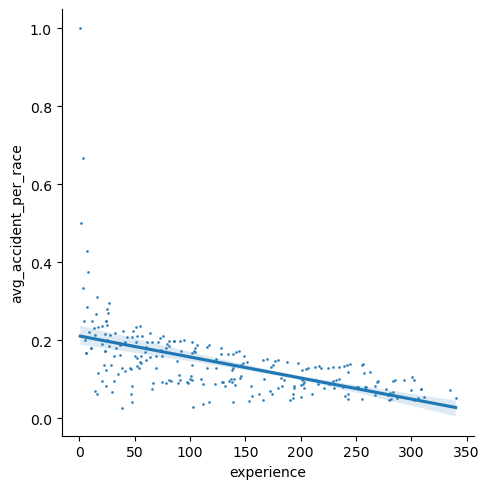

In [113]:
histogram = sns.lmplot(data=sorted, x='experience', y='avg_accident_per_race', fit_reg=True, scatter_kws={'s':1})

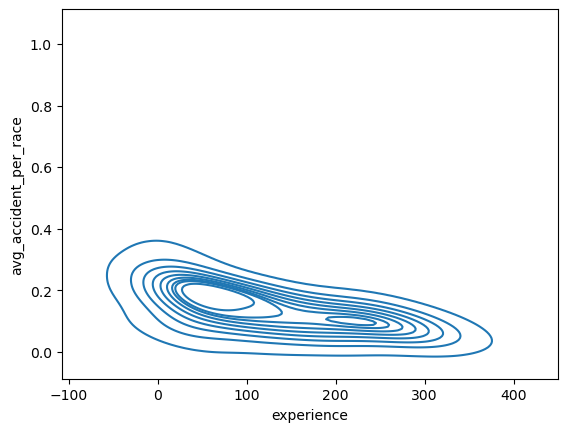

In [114]:
histogram = sns.kdeplot(data=sorted, x='experience', y='avg_accident_per_race')

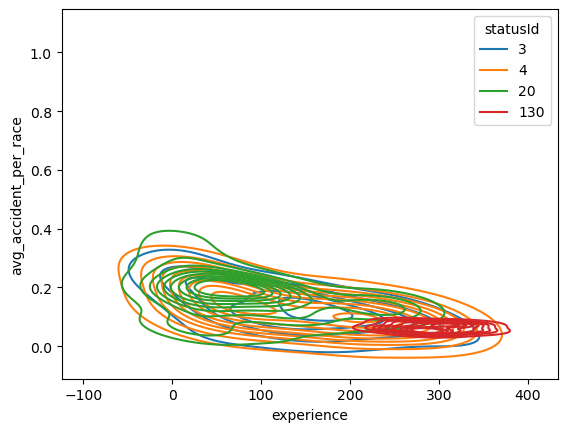

In [115]:
histogram = sns.kdeplot(data=sorted, x='experience', y='avg_accident_per_race', hue='statusId', palette=sns.color_palette(["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]))

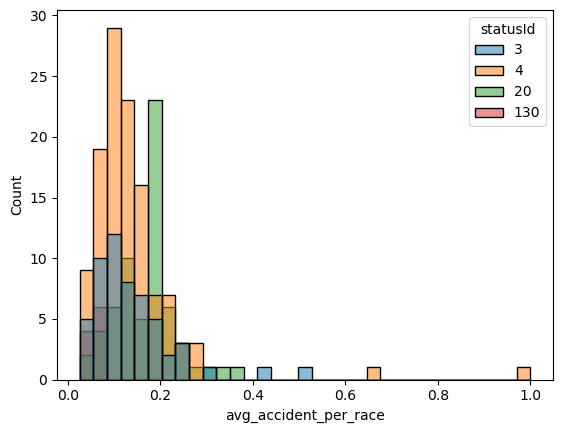

In [116]:
histogram = sns.histplot(data=sorted, x='avg_accident_per_race', hue='statusId', palette=sns.color_palette(["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]))

In [117]:
print(sorted['avg_accident_per_race'].corr(sorted['experience']))

-0.522329837106304


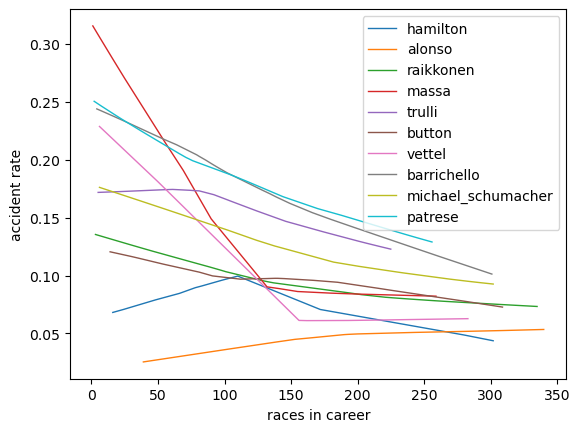

In [120]:
from statsmodels.nonparametric.smoothers_lowess import lowess

driverss = grouped_experience.index
for driver in driverss:
    y = sorted.loc[(sorted['driverId'] == driver), 'avg_accident_per_race']
    x = sorted.loc[(sorted['driverId'] == driver), 'experience']
    ysmooth = lowess(y, x, return_sorted=False)
    sns.lineplot(x=x, y=ysmooth, label=drivers.loc[drivers['driverId'] == driver, 'driverRef'].values[0], linewidth=1)

plt.ylabel('accident rate')
plt.xlabel('races in career')
plt.show()